# Transformer NMT

In this notebook we use a transformer to generate translations from Portuguese to English. This largely follows the tutorial <a href="https://www.tensorflow.org/text/tutorials/transformer">here</a> and references <a href="https://arxiv.org/pdf/1706.03762.pdf">this</a> paper (that introduced the Transformer).

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd
import pathlib
import re
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import time

path = pathlib.Path(getcwd())
p = str(path.parent.parent.parent.absolute())
if p not in sys.path:
    sys.path.append(p)

import custom_helper_functions as helper_functions

plt.style.use('dark_background')

## Loading the Dataset

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', as_supervised=True, with_info=True)
train_examples, val_examples = examples['train'], examples['validation']
train_en = train_examples.map(lambda pt, en: en)
train_pt = train_examples.map(lambda pt, en: pt)

## Generating the Tokenizers

In [3]:
bert_tokenizer_params = {
    'lower_case': True
}
reserved_tokens = ['[PAD]', '[UNK]', '[START]', '[END]']
bert_vocab_args = {
    'bert_tokenizer_params': bert_tokenizer_params,
    'learn_params': {},
    'reserved_tokens': reserved_tokens,
    'vocab_size': 8000
}

en_vocab = bert_vocab.bert_vocab_from_dataset(train_en.batch(1000).prefetch(tf.data.AUTOTUNE), **bert_vocab_args)
pt_vocab = bert_vocab.bert_vocab_from_dataset(train_pt.batch(1000).prefetch(tf.data.AUTOTUNE), **bert_vocab_args)

def write_vocab_file(filepath, vocab):
    with open('vocab\\'+filepath, 'w', encoding='utf-7') as f:
        for token in vocab:
            print(token, file=f)

write_vocab_file('en_vocab.txt', en_vocab)
write_vocab_file('pt_vocab.txt', pt_vocab)

en_tokenizer = tf_text.BertTokenizer('vocab\\en_vocab.txt', **bert_tokenizer_params)
pt_tokenizer = tf_text.BertTokenizer('vocab\\pt_vocab.txt', **bert_tokenizer_params)

START = tf.argmax(tf.constant(reserved_tokens) == '[START]')
END = tf.argmax(tf.constant(reserved_tokens) == '[END]')

def add_start_end(ragged):
    count = ragged.bounding_shape()[0]
    starts = tf.fill([count, 1], START)
    ends = tf.fill([count, 1], END)
    return tf.concat([starts, ragged, ends], axis=1)

def cleanup_text(reserved_tokens, token_txt):
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_cells = tf.strings.regex_full_match(token_txt, bad_tokens_re)
    result = tf.ragged.boolean_mask(token_txt, ~bad_cells)
    result = tf.strings.reduce_join(result, axis=-1, separator=' ')
    return result

class CustomTokenizer(tf.Module):
    def __init__(self, reserved_tokens, vocab_path):
        self.tokenizer = tf_text.BertTokenizer(vocab_path, lower_case=True)
        self._reserved_tokens = reserved_tokens
        self._vocab_path = tf.saved_model.Asset(vocab_path)

        vocab = pathlib.Path(vocab_path).read_text().splitlines()
        self.vocab = tf.Variable(vocab)
        self.tokenize.get_concrete_function(tf.TensorSpec(shape=[None], dtype=tf.string))
        self.detokenize.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64)
        )
        self.detokenize.get_concrete_function(
            tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64)
        )

        self.lookup.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64)
        )
        self.lookup.get_concrete_function(
            tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64)
        )

        self.get_vocab_size.get_concrete_function()
        self.get_vocab_path.get_concrete_function()
        self.get_reserved_tokens.get_concrete_function()

    @tf.function
    def tokenize(self, strings):
        enc = self.tokenizer.tokenize(strings)
        enc = enc.merge_dims(-2, -1)
        enc = add_start_end(enc)
        return enc

    @tf.function
    def detokenize(self, tokenized):
        words = self.tokenizer.detokenize(tokenized)
        return cleanup_text(self._reserved_tokens, words)

    @tf.function
    def lookup(self, token_ids):
        return tf.gather(self.vocab, token_ids)

    @tf.function
    def get_vocab_size(self):
        return tf.shape(self.vocab)[0]

    @tf.function
    def get_vocab_path(self):
        return self._vocab_path

    @tf.function
    def get_reserved_tokens(self):
        return tf.constant(self._reserved_tokens)

tokenizers = tf.Module()
tokenizers.en = CustomTokenizer(reserved_tokens, 'vocab\\en_vocab.txt')
tokenizers.pt = CustomTokenizer(reserved_tokens, 'vocab\\pt_vocab.txt')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Processing the Dataset

In [4]:
batch_size = 64
buffer_size = 20000

def tokenize_pairs(pt, en):
    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()

    pt = tokenizers.pt.tokenize(pt)
    pt = pt.to_tensor()

    return pt, en

def make_batches(ds):
    return (
        ds
        .cache()
        .shuffle(buffer_size)
        .batch(batch_size)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
        )

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Defining the Model

In [6]:
# Positional Encoding

def get_angles(pos, i, d_model):
    angle_rates = 1/np.power(10000, (2*(i//2))/np.float32(d_model))
    return pos*angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # Apply sin to even indices in the array
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # Apply cos to odd indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)
    
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)

# Masking

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_lookahead_mask(size):
    mask = 1-tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

# Attention

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)

    if mask is not None:
        # Multiply by a large negative value to essentially set the output of softmax
        # to zero
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q ,mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask
        )
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        
        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    # The paper calls this "position-wise" instead of point-wise
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x+attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1+ffn_output)

        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1+x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output+out2)

        return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer that all input is passed in the first argument
        inp, tar = inputs
        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        enc_padding_mask = create_padding_mask(inp)

        # This padding mask is used to mask the encoder outputs
        dec_padding_mask = create_padding_mask(inp) 
        
        look_ahead_mask = create_lookahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

## Creating the Model

In [19]:
# Custom Reduced Model
d_model = 128
dff = 256
dropout_rate = 0.1
num_heads = 4
num_layers = 2

# # Tutorial Reduced Model
# d_model = 128
# dff = 512
# dropout_rate = 0.1
# num_heads = 8
# num_layers = 4

# # Model from the Original Paper
# d_model = 512
# dff = 2048
# dropout_rate = 0.1
# num_heads = 8
# num_layers = 6

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask) # This is an average loss

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

transformer = Transformer(
    d_model=d_model,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    num_heads=num_heads,
    num_layers=num_layers,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate,
    target_vocab_size=tokenizers.en.get_vocab_size().numpy()
)

## Training the Model

In [20]:
checkpoint_path = 'checkpoints\\train'
ckpt = tf.train.Checkpoint(optimizer=optimizer, transformer=transformer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

epochs = 20

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp  = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp], training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

for epoch in range(epochs):
    start = time.time()

    train_accuracy.reset_states()
    train_loss.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch+1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch+1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8710 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8228 Accuracy 0.0030
Epoch 1 Batch 100 Loss 8.7242 Accuracy 0.0239
Epoch 1 Batch 150 Loss 8.6066 Accuracy 0.0318
Epoch 1 Batch 200 Loss 8.4650 Accuracy 0.0353
Epoch 1 Batch 250 Loss 8.2967 Accuracy 0.0374
Epoch 1 Batch 300 Loss 8.1071 Accuracy 0.0390
Epoch 1 Batch 350 Loss 7.9113 Accuracy 0.0429
Epoch 1 Batch 400 Loss 7.7240 Accuracy 0.0492
Epoch 1 Batch 450 Loss 7.5567 Accuracy 0.0553
Epoch 1 Batch 500 Loss 7.4115 Accuracy 0.0623
Epoch 1 Batch 550 Loss 7.2769 Accuracy 0.0700
Epoch 1 Batch 600 Loss 7.1512 Accuracy 0.0782
Epoch 1 Batch 650 Loss 7.0364 Accuracy 0.0859
Epoch 1 Batch 700 Loss 6.9264 Accuracy 0.0935
Epoch 1 Batch 750 Loss 6.8243 Accuracy 0.1008
Epoch 1 Batch 800 Loss 6.7299 Accuracy 0.1075
Epoch 1 Loss 6.7134 Accuracy 0.1088
Time taken for 1 epoch: 83.07 secs

Epoch 2 Batch 0 Loss 4.9801 Accuracy 0.2436
Epoch 2 Batch 50 Loss 5.1781 Accuracy 0.2215
Epoch 2 Batch 100 Loss 5.1485 Accuracy 0.2262
Epoch 2 Batch 

## Creating an End to End Model to Run Inference

In [38]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=20):
        assert isinstance(sentence, tf.Tensor)
        
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

        encoder_input = sentence

        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        output_array = tf.TensorArray(dtype=tf.int64, dynamic_size=True, size=0)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions, _ = self.transformer([encoder_input, output], training=False)
            predictions = predictions[:, -1:, :]
            predicted_id = tf.argmax(predictions, axis=-1)
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        text = tokenizers.en.detokenize(output)[0]
        tokens = tokenizers.en.lookup(output)[0]

        # The last attention weights from inside the loop can't be used due to tf.function
        # (which will be applied to this function later)
        _, attention_weights = self.transformer([encoder_input, output[:, :-1]], training=False)
        return text, tokens, attention_weights

translator = Translator(tokenizers, transformer)

## Visualizing Attention

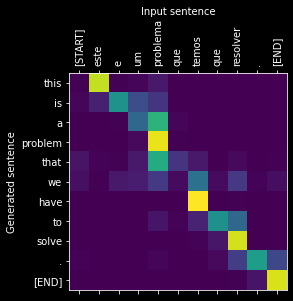

In [31]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The plot shows tokens generated by the model and the model didn't
    # generate the start token
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))
    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)
    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)
    ax.set_xlabel('Input sentence')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Generated sentence')

sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))

head = 0
attention_heads = tf.squeeze(attention_weights['decoder_layer2_block2'], 0)
attention = attention_heads[head]
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]

plot_attention_head(in_tokens, translated_tokens, attention)

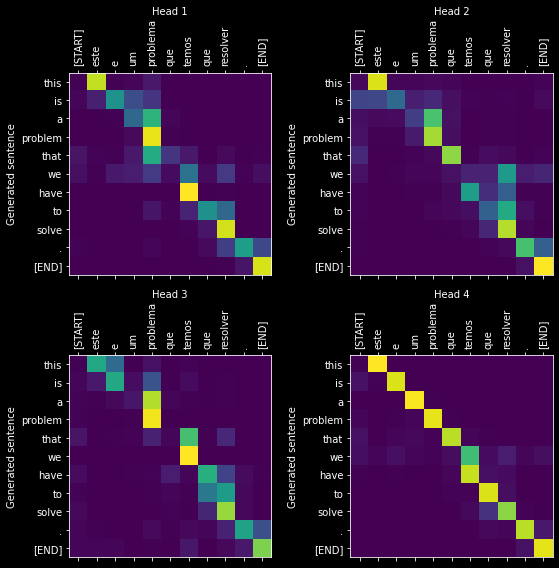

In [34]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]
    
    fig = plt.figure(figsize=(8, 8))
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 2, h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

plot_attention_weights(sentence, translated_tokens, attention_weights['decoder_layer2_block2'][0])

## Saving the Model

In [39]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        result, tokens, attention_weights = self.translator(sentence, max_length=100)
        return result

export_translator = ExportTranslator(translator)
tf.saved_model.save(export_translator, export_dir='models\\Transformer')
reloaded = tf.saved_model.load('models\\Transformer')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: models\Transformer\assets


INFO:tensorflow:Assets written to: models\Transformer\assets
